In [1]:
import geopandas as gpd
import pandas as pd
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from os.path import join
import descartes
from PIL import Image

import fiona 
import pyproj
import time
import re

import warnings

from pprint import pprint

In [2]:
# local paths
path_data_local_train = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset'
path_data_local_test = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Evaluation_Dataset'

In [3]:
dict_seasons = {'winter':['01', '02', '03'] , 
                'spring':['04', '05', '06'],
                'summer':['07', '08', '09'], 
                'autumn':['10', '11', '12']}
list_polarizations = ['vh', 'vv']

seasons_fixed_order = ['winter', 'spring', 'summer', 'autumn']

# loading

In [62]:
def paths_in_dict(path_data_local):
    dict_paths = dict()
    
    list_areas_year = [dir_area for dir_area in os.listdir(path_data_local) 
                       if os.path.isdir(join(path_data_local, dir_area))]
    if list_areas_year:
        str_year = list_areas_year[0].split('_')[1]
        list_areas = [area_year.split('_')[0] for area_year in list_areas_year]
    else:
        return {}
            
    for area in list_areas:
        dict_paths[area] = dict()
            
        # .tif files
        dict_paths[area]['tif'] = dict()
        for season, list_months in dict_seasons.items():
            dict_paths[area]['tif'][season] = dict()

            for month in list_months:
                for pol in list_polarizations:
                    str_pol = "_" + pol + "_"
                    year_month = str_year + month

                    for root, dirs, files in os.walk(path_data_local):
                        for file in files:
                            path_file = join(root, file)
                            if re.search(area + ".*" + str_pol + ".*" + year_month + ".*.tif$", path_file):
                                if not 'BorderMask' in file:
                                    dict_paths[area]['tif'][season][pol] = path_file
          
        # .shp files
        for root, dirs, files in os.walk(path_data_local):
            for file in files:
                path_file = join(root, file)
                if re.search(area + ".*.shp$", file):
                    dict_paths[area]['shp'] = path_file
                       
    return dict_paths

In [63]:
dict_data_train = paths_in_dict(path_data_local_train)
dict_data_test = paths_in_dict(path_data_local_test)

In [64]:
dict_data_train['Mosul']['shp']

'/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/38SLF_Mosul.shp'

In [12]:
def tif2raster(dict_data):
    dict_raster_layers = dict()

    for area in dict_data:
        dict_raster_layers[area] = []

        for season in seasons_fixed_order:
            for pol in sorted(dict_data[area]['tif'][season]):
                path_raster = dict_data[area]['tif'][season][pol]
                raster_obj = rio.open(path_raster)
                dict_raster_layers[area].append((season, pol, raster_obj))
                
    return dict_raster_layers 

In [55]:
def shp2polygons(dict_data):
    dict_polygons = dict()
    
    for area in dict_data:
        for season in seasons_fixed_order:
            path_shape = dict_data[area]['shp']
            polygons = gpd.read_file(path_shape)
            dict_polygons[area] = polygons
            
    return dict_polygons

### testing

In [65]:
dict_polygons = shp2polygons(dict_data_train)
dict_polygons.keys()

dict_keys(['Mosul', 'Najaf', 'Nasiryah', 'Souleimaniye'])

In [66]:
area_test = 'Mosul'
polygons = shp2polygons(dict_data_train)[area_test]
raster_obj_test = tif2raster(dict_data_train)[area_test][1][2]
raster_obj_test 

<open DatasetReader name='/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif' mode='r'>

In [67]:
raster_obj_test.crs

CRS.from_epsg(32638)

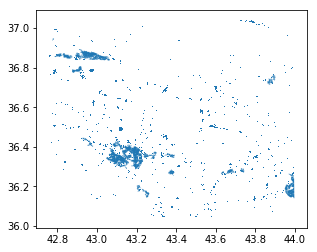

In [68]:
polygons.plot()

In [69]:
polygons_resh = polygons.to_crs(raster_obj_test.crs)
geoms = polygons_resh['geometry']
geom = polygons_resh.iloc[0]['geometry']

In [70]:
polygon_mask = rio.features.geometry_mask(geometries=geoms,
                                   out_shape=(raster_obj_test.height, raster_obj_test.width),
                                   transform=raster_obj_test.transform,
                                   all_touched=False,
                                   invert=True)
print('polygon mask shape:', polygon_mask.shape)

polygon mask shape: (10980, 10979)


In [71]:
polygon_mask_int = np.multiply(polygon_mask, 1)
print('sum polygon_mask_int:', sum(sum(polygon_mask_int)))

sum polygon_mask_int: 4316046


# preprocessing 

### raster

In [7]:
quantile_clip_max = 0.999
dir_save_arrays = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/data_temp/np_arrays'
dir_save_plots =  '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/data_temp/plots'

In [8]:
def exponent(x, a, b):
    return a*x**b

def log(x, a, b):
    return np.log(a*x + b)

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)


def process_image(np_arr, quantile_clip_max, clip_min=0, plotting=False, **kwargs_plotting):
    # need to clip and normalize contrast of figure
    clip_max = np.quantile(np_arr, quantile_clip_max)
    arr_clip = np.clip(np_arr, clip_min, clip_max)
    np_arr_norm = normalize(arr_clip)
    
    if plotting:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.hist(np_arr_norm.flatten(), bins=100)
        title = ''.join([val + '-' for val in kwargs_plotting.values()]) 
        ax.set_title(title)
        fig.savefig(join(dir_save_plots, title + '.png'))
        plt.close()
    
    return np_arr_norm 

In [11]:
dict_raster_layers = tif2raster(dict_data_train)

In [12]:
pprint(dict_raster_layers)

{'Mosul': [('winter',
            'vh',
            <open DatasetReader name='/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vh_DES_20150108t030926.tif' mode='r'>),
           ('winter',
            'vv',
            <open DatasetReader name='/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif' mode='r'>),
           ('spring',
            'vh',
            <open DatasetReader name='/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling_S1A_IW_GRDH_1SDV_20150426T030931_20150426T030956_005649_0073E6_2DFA/38SLF/s1a_38SLF_vh_20150426.tif' mode='r'>),
           ('spring',
            'vv',
            <open DatasetReader name='/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling

In [ ]:
def np_arr2polygon_mask(polygons, raster_obj):
    polygons_resh = polygons.to_crs(raster_obj.crs)
    geoms = polygons_resh['geometry']
    
    polygon_mask = rio.features.geometry_mask(geometries=geoms,
                                       out_shape=(raster_obj.height, raster_obj.width),
                                       transform=raster_obj.transform,
                                       all_touched=False,
                                       invert=True)
    print('polygon mask shape:', polygon_mask.shape)
    
    polygon_mask_int = np.multiply(polygon_mask, 1)
    print('sum polygon_mask_int:', sum(sum(polygon_mask_int)))
    return polygon_mask_int
    

In [23]:
def create_training_data(dict_data_train, quantile_clip_max):
    dict_arrays = dict()
    dict_labels = dict()
    
    dict_raster_layers = tif2raster(dict_data_train)
    dict_polygons = shp2polygons(dict_data_train)
    
    for area in dict_raster_layers:
        print(area)
        list_np_arrs_area = []
        for season, pol, raster_obj in dict_raster_layers[area]:
            print(' ', season, pol)
            np_arr = raster_obj.read()[0]
            np_arr_norm = process_image(np_arr, quantile_clip_max,  clip_min=0, plotting=False, 
                                        area=area,  season=season, pol=pol)
            list_np_arrs_area.append((season, pol, np_arr_norm))

        dict_arrays[area] = list_np_arrs_area
        dict_labels[area] = np_arr2polygon_mask(dict_polygons[area], raster_obj)
        
    return dict_arrays, dict_labels

In [24]:
dict_arrays, dict_labels = create_training_data(dict_data_train, quantile_clip_max)

Mosul
  winter vh
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv


NameError: name 'np_arr2polygon_mask' is not defined

In [25]:
def save_stacked_arrays(dict_arrays, dir_save_arrays):
    for area in dict_arrays:
        print(area)
        list_np_arrs_area = []
        for season, pol, arr in dict_arrays[area]:
            list_np_arrs_area.append(arr)
        
        path_save = join(dir_save_arrays, area)
        np.save(path_save, np.array(list_np_arrs_area))

In [26]:
dict_arrays_stacked = save_stacked_arrays(dict_arrays, dir_save_arrays)

Mosul
Najaf
Nasiryah
Souleimaniye


In [ ]:
def save_labels():
    pass